# MERLIN Anomaly Detection on SeizeIT2 Data

This notebook demonstrates MERLIN (Parameter-Free Discovery of Arbitrary Length Anomalies) on real preprocessed ECG data from the SeizeIT2 dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add the Information/Merlin directory to path to import MERLIN
sys.path.append(os.path.join('..', 'Information', 'Merlin'))

try:
    from _merlin import MERLIN
    print("✓ MERLIN successfully imported from Information/Merlin")
    MERLIN_AVAILABLE = True
except ImportError:
    print(" MERLIN import failed")
    MERLIN_AVAILABLE = False

print(f"MERLIN available: {MERLIN_AVAILABLE}")

✓ MERLIN successfully imported from Information/Merlin
MERLIN available: True


## 1. Load Preprocessed SeizeIT2 Data

In [2]:
# Path to preprocessed data
data_path = Path("../results/preprocessed_all/sub-001_run-03_preprocessed.pkl")

# Load the preprocessed data
print(f"Loading preprocessed data from: {data_path}")

try:
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    
    print("✓ Data loaded successfully")
    print(f"Subject: {data['subject_id']} {data['run_id']}")
    print(f"Recording duration: {data['recording_duration']:.1f} seconds ({data['recording_duration']/3600:.1f} hours)")
    print(f"Total seizures: {data['total_seizures']}")
    print(f"Number of channels: {len(data['channels'])}")
    
    # Get first channel info
    channel = data['channels'][0]
    print(f"\nChannel: {channel['channel_name']}")
    print(f"Number of windows: {channel['n_windows']}")
    print(f"Seizure windows: {channel['n_seizure_windows']}")
    print(f"Original sampling rate: {channel['original_fs']} Hz")
    print(f"Processed sampling rate: {channel['processed_fs']} Hz")
    print(f"Window size: {len(channel['windows'][0])} samples ({len(channel['windows'][0])/channel['processed_fs']} seconds)")
    
    # Display preprocessing parameters
    print(f"\nPreprocessing parameters:")
    for key, value in data['preprocessing_params'].items():
        print(f"  {key}: {value}")
        
except FileNotFoundError:
    print(f"❌ Data file not found: {data_path}")
    print("Please ensure the data has been preprocessed first.")
    data = None
except Exception as e:
    print(f"❌ Error loading data: {e}")
    data = None

Loading preprocessed data from: ../results/preprocessed_all/sub-001_run-03_preprocessed.pkl
✓ Data loaded successfully
Subject: sub-001 run-03
Recording duration: 64979.0 seconds (18.0 hours)
Total seizures: 1
Number of channels: 1

Channel: ECG SD
Number of windows: 4434
Seizure windows: 6
Original sampling rate: 256 Hz
Processed sampling rate: 125 Hz
Window size: 3750 samples (30.0 seconds)

Preprocessing parameters:
  filter_params: {'low_freq': 0.5, 'high_freq': 40.0, 'order': 4}
  downsample_freq: 125
  window_size: 30.0
  stride: 15.0


## 2. Explore Data Structure and Labels

In [3]:
if data is not None:
    channel = data['channels'][0]  # Use first ECG channel
    
    # Analyze label distribution
    labels = np.array(channel['labels'])
    normal_windows = np.sum(labels == 0)
    seizure_windows = np.sum(labels == 1)
    
    print(f"Label Distribution:")
    print(f"  Normal windows: {normal_windows} ({normal_windows/len(labels)*100:.2f}%)")
    print(f"  Seizure windows: {seizure_windows} ({seizure_windows/len(labels)*100:.2f}%)")
    
    # Find seizure window indices
    seizure_indices = np.where(labels == 1)[0]
    print(f"  Seizure window indices: {seizure_indices}")
    
    # Sample data statistics
    sample_window = channel['windows'][0]
    print(f"\nSample window statistics:")
    print(f"  Shape: {sample_window.shape}")
    print(f"  Data type: {sample_window.dtype}")
    print(f"  Range: {np.min(sample_window):.2f} to {np.max(sample_window):.2f}")
    print(f"  Mean: {np.mean(sample_window):.2f}")
    print(f"  Std: {np.std(sample_window):.2f}")
    
    # Time information from metadata
    if seizure_indices.size > 0:
        seizure_metadata = channel['metadata'][seizure_indices[0]]
        print(f"\nFirst seizure window metadata:")
        for key, value in seizure_metadata.items():
            print(f"  {key}: {value}")
else:
    print("❌ No data available for exploration")

Label Distribution:
  Normal windows: 4428 (99.86%)
  Seizure windows: 6 (0.14%)
  Seizure window indices: [3864 3865 3866 3867 3868 3869]

Sample window statistics:
  Shape: (3750,)
  Data type: float64
  Range: -107.90 to 534.96
  Mean: 0.11
  Std: 65.67

First seizure window metadata:
  start_time: 57960.0
  end_time: 57990.0
  start_idx: 7245000
  end_idx: 7248750
  sampling_rate: 125


## 3. Visualize Sample Windows

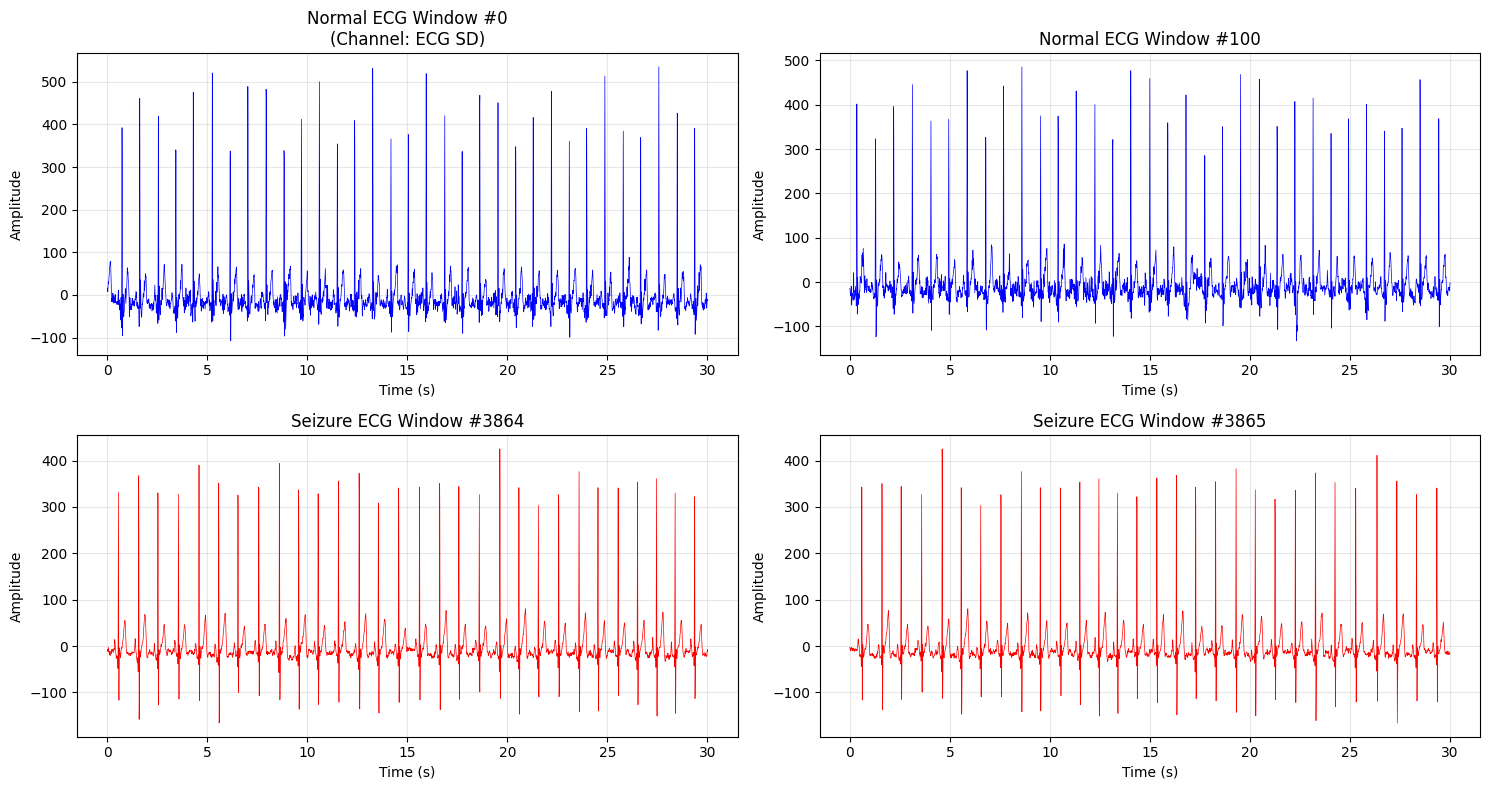

Window Characteristics:
  Duration: 30.0 seconds
  Samples per window: 3750
  Sampling rate: 125 Hz
  Total windows: 4434
  Normal windows: 4428
  Seizure windows: 6


In [4]:
if data is not None:
    channel = data['channels'][0]
    labels = np.array(channel['labels'])
    fs = channel['processed_fs']
    
    # Create time axis for 30-second window
    window_duration = len(channel['windows'][0]) / fs
    time_axis = np.linspace(0, window_duration, len(channel['windows'][0]))
    
    # Plot examples of normal and seizure windows
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    
    # Normal windows
    normal_indices = np.where(labels == 0)[0]
    
    # Plot first normal window
    normal_window_1 = channel['windows'][normal_indices[0]]
    axes[0,0].plot(time_axis, normal_window_1, 'b-', linewidth=0.5)
    axes[0,0].set_title(f'Normal ECG Window #{normal_indices[0]}\n(Channel: {channel["channel_name"]})')
    axes[0,0].set_xlabel('Time (s)')
    axes[0,0].set_ylabel('Amplitude')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot second normal window
    normal_window_2 = channel['windows'][normal_indices[100]]  # Different normal window
    axes[0,1].plot(time_axis, normal_window_2, 'b-', linewidth=0.5)
    axes[0,1].set_title(f'Normal ECG Window #{normal_indices[100]}')
    axes[0,1].set_xlabel('Time (s)')
    axes[0,1].set_ylabel('Amplitude')
    axes[0,1].grid(True, alpha=0.3)
    
    # Seizure windows (if available)
    seizure_indices = np.where(labels == 1)[0]
    
    if len(seizure_indices) > 0:
        # Plot first seizure window
        seizure_window_1 = channel['windows'][seizure_indices[0]]
        axes[1,0].plot(time_axis, seizure_window_1, 'r-', linewidth=0.5)
        axes[1,0].set_title(f'Seizure ECG Window #{seizure_indices[0]}')
        axes[1,0].set_xlabel('Time (s)')
        axes[1,0].set_ylabel('Amplitude')
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot second seizure window if available
        if len(seizure_indices) > 1:
            seizure_window_2 = channel['windows'][seizure_indices[1]]
            axes[1,1].plot(time_axis, seizure_window_2, 'r-', linewidth=0.5)
            axes[1,1].set_title(f'Seizure ECG Window #{seizure_indices[1]}')
        else:
            # Plot zoomed view of first seizure window
            axes[1,1].plot(time_axis[:1250], seizure_window_1[:1250], 'r-', linewidth=0.8)
            axes[1,1].set_title(f'Seizure Window #{seizure_indices[0]} (First 10s)')
        
        axes[1,1].set_xlabel('Time (s)')
        axes[1,1].set_ylabel('Amplitude')
        axes[1,1].grid(True, alpha=0.3)
    else:
        # No seizure windows available
        axes[1,0].text(0.5, 0.5, 'No seizure windows\navailable in this recording', 
                      ha='center', va='center', transform=axes[1,0].transAxes, fontsize=12)
        axes[1,0].set_title('Seizure Windows')
        axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display window statistics
    print(f"Window Characteristics:")
    print(f"  Duration: {window_duration} seconds")
    print(f"  Samples per window: {len(channel['windows'][0])}")
    print(f"  Sampling rate: {fs} Hz")
    print(f"  Total windows: {len(channel['windows'])}")
    print(f"  Normal windows: {len(normal_indices)}")
    print(f"  Seizure windows: {len(seizure_indices)}")
else:
    print("❌ No data available for visualization")

## 4. MERLIN Configuration for ECG Data

In [5]:
if data is not None:
    channel = data['channels'][0]
    fs = channel['processed_fs']  # 125 Hz
    window_samples = len(channel['windows'][0])  # 3750 samples (30 seconds)
    
    # MERLIN parameter configurations for ECG analysis
    # Based on ECG characteristics and seizure detection requirements
    
    merlin_configs = [
        {
            "name": "Short-term (1-5s)",
            "min_length": int(1 * fs),    # 1 second = 125 samples
            "max_length": int(5 * fs),    # 5 seconds = 625 samples
            "description": "Detect rapid ECG changes and artifacts"
        },
        {
            "name": "Medium-term (2-10s)",
            "min_length": int(2 * fs),    # 2 seconds = 250 samples
            "max_length": int(10 * fs),   # 10 seconds = 1250 samples
            "description": "Capture seizure-related rhythm changes"
        },
        {
            "name": "Long-term (5-15s)",
            "min_length": int(5 * fs),    # 5 seconds = 625 samples
            "max_length": int(15 * fs),   # 15 seconds = 1875 samples
            "description": "Detect sustained seizure patterns"
        }
    ]
    
    print(f"MERLIN Configuration for ECG Data (fs = {fs} Hz):")
    print(f"Window size: {window_samples} samples ({window_samples/fs:.1f} seconds)")
    print(f"\nProposed MERLIN configurations:")
    
    for i, config in enumerate(merlin_configs):
        min_sec = config['min_length'] / fs
        max_sec = config['max_length'] / fs
        print(f"\n{i+1}. {config['name']}:")
        print(f"   Min length: {config['min_length']} samples ({min_sec:.1f}s)")
        print(f"   Max length: {config['max_length']} samples ({max_sec:.1f}s)")
        print(f"   Purpose: {config['description']}")
    
    # Check if configurations are valid for our window size
    print(f"\nConfiguration Validation:")
    for config in merlin_configs:
        max_length = config['max_length']
        min_required = max_length * 2  # MERLIN requires at least 2x max_length
        
        if window_samples >= min_required:
            print(f"✓ {config['name']}: Valid (requires {min_required}, have {window_samples})")
        else:
            print(f"❌ {config['name']}: Invalid (requires {min_required}, have {window_samples})")
    
    # Filter valid configurations
    valid_configs = []
    for config in merlin_configs:
        if window_samples >= config['max_length'] * 2:
            valid_configs.append(config)
    
    print(f"\nValid configurations: {len(valid_configs)}/{len(merlin_configs)}")
    
else:
    print("❌ No data available for configuration")
    valid_configs = []

MERLIN Configuration for ECG Data (fs = 125 Hz):
Window size: 3750 samples (30.0 seconds)

Proposed MERLIN configurations:

1. Short-term (1-5s):
   Min length: 125 samples (1.0s)
   Max length: 625 samples (5.0s)
   Purpose: Detect rapid ECG changes and artifacts

2. Medium-term (2-10s):
   Min length: 250 samples (2.0s)
   Max length: 1250 samples (10.0s)
   Purpose: Capture seizure-related rhythm changes

3. Long-term (5-15s):
   Min length: 625 samples (5.0s)
   Max length: 1875 samples (15.0s)
   Purpose: Detect sustained seizure patterns

Configuration Validation:
✓ Short-term (1-5s): Valid (requires 1250, have 3750)
✓ Medium-term (2-10s): Valid (requires 2500, have 3750)
✓ Long-term (5-15s): Valid (requires 3750, have 3750)

Valid configurations: 3/3


## 5. Run MERLIN on Sample Windows

In [7]:
def run_merlin_on_window(window_data, config, fs=125):
    """
    Run MERLIN anomaly detection on a single ECG window
    
    Args:
        window_data (np.array): ECG window data
        config (dict): MERLIN configuration
        fs (int): Sampling frequency
    
    Returns:
        dict: Detection results
    """
    start_time = time.time()
    
    # Initialize MERLIN
    detector = MERLIN(
        min_length=config['min_length'],
        max_length=config['max_length'],
        max_iterations=50
    )
    
    try:
        # Run detection
        anomalies = detector.fit_predict(window_data.astype(np.float64))
        detection_time = time.time() - start_time
        
        # Calculate statistics
        n_anomalies = np.sum(anomalies)
        anomaly_rate = n_anomalies / len(window_data) * 100
        
        # Find anomaly regions (consecutive anomaly points)
        anomaly_regions = []
        if n_anomalies > 0:
            anomaly_indices = np.where(anomalies)[0]
            
            if len(anomaly_indices) > 0:
                # Group consecutive indices
                region_start = anomaly_indices[0]
                region_end = anomaly_indices[0]
                
                for i in range(1, len(anomaly_indices)):
                    if anomaly_indices[i] == region_end + 1:
                        region_end = anomaly_indices[i]
                    else:
                        # Add completed region
                        anomaly_regions.append({
                            'start_sample': region_start,
                            'end_sample': region_end,
                            'start_time': region_start / fs,
                            'end_time': region_end / fs,
                            'duration': (region_end - region_start + 1) / fs
                        })
                        region_start = anomaly_indices[i]
                        region_end = anomaly_indices[i]
                
                # Add final region
                anomaly_regions.append({
                    'start_sample': region_start,
                    'end_sample': region_end,
                    'start_time': region_start / fs,
                    'end_time': region_end / fs,
                    'duration': (region_end - region_start + 1) / fs
                })
        
        return {
            'success': True,
            'anomalies': anomalies,
            'n_anomalies': n_anomalies,
            'anomaly_rate': anomaly_rate,
            'anomaly_regions': anomaly_regions,
            'detection_time': detection_time,
            'config': config
        }
        
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'detection_time': time.time() - start_time,
            'config': config
        }


if data is not None and valid_configs:
    channel = data['channels'][0]
    labels = np.array(channel['labels'])
    fs = channel['processed_fs']
    
    # Select test windows: normal and seizure (if available)
    normal_indices = np.where(labels == 0)[0]
    seizure_indices = np.where(labels == 1)[0]
    
    # Test windows to analyze
    test_windows = []
    
    # Add normal window
    test_windows.append({
        'index': normal_indices[0],
        'type': 'normal',
        'data': channel['windows'][normal_indices[0]],
        'label': labels[normal_indices[0]]
    })
    
    # Add seizure window if available
    if len(seizure_indices) > 0:
        test_windows.append({
            'index': seizure_indices[0],
            'type': 'seizure',
            'data': channel['windows'][seizure_indices[0]],
            'label': labels[seizure_indices[0]]
        })
    
    print(f"Testing MERLIN on {len(test_windows)} windows:")
    for window in test_windows:
        print(f"  - Window #{window['index']}: {window['type']} (label: {window['label']})")
    
    # Run MERLIN with different configurations
    results_summary = []
    
    print(f"\n{'='*80}")
    print(f"MERLIN DETECTION RESULTS")
    print(f"{'='*80}")
    
    for config in valid_configs:
        print(f"\nConfiguration: {config['name']}")
        print(f"  Window range: {config['min_length']}-{config['max_length']} samples")
        print(f"  Time range: {config['min_length']/fs:.1f}-{config['max_length']/fs:.1f} seconds")
        
        config_results = []
        
        for window in test_windows:
            print(f"\n  Testing on {window['type']} window #{window['index']}:")
            
            result = run_merlin_on_window(window['data'], config, fs)
            config_results.append(result)
            
            if result['success']:
                print(f"    ✓ Detection completed in {result['detection_time']:.3f}s")
                print(f"    ✓ Found {result['n_anomalies']} anomaly points ({result['anomaly_rate']:.2f}%)")
                print(f"    ✓ Found {len(result['anomaly_regions'])} anomaly regions")
                
                # Show first few regions
                if result['anomaly_regions']:
                    print(f"    ✓ Sample regions:")
                    for i, region in enumerate(result['anomaly_regions'][:3]):
                        print(f"      {i+1}. {region['start_time']:.2f}s - {region['end_time']:.2f}s ({region['duration']:.3f}s)")
                    if len(result['anomaly_regions']) > 3:
                        print(f"      ... and {len(result['anomaly_regions']) - 3} more")
            else:
                print(f"    ❌ Detection failed: {result['error']}")
        
        results_summary.append({
            'config': config,
            'results': config_results
        })
    
    print(f"\n✓ MERLIN testing completed on {len(test_windows)} windows with {len(valid_configs)} configurations")
    
else:
    print("❌ No data or valid configurations available for testing")
    results_summary = []

Testing MERLIN on 2 windows:
  - Window #0: normal (label: 0)
  - Window #3864: seizure (label: 1)

MERLIN DETECTION RESULTS

Configuration: Short-term (1-5s)
  Window range: 125-625 samples
  Time range: 1.0-5.0 seconds

  Testing on normal window #0:
    ✓ Detection completed in 1574.903s
    ✓ Found 205 anomaly points (5.47%)
    ✓ Found 5 anomaly regions
    ✓ Sample regions:
      1. 1.64s - 1.64s (0.008s)
      2. 2.57s - 3.46s (0.904s)
      3. 3.48s - 3.48s (0.008s)
      ... and 2 more

  Testing on seizure window #3864:
    ✓ Detection completed in 1428.933s
    ✓ Found 172 anomaly points (4.59%)
    ✓ Found 24 anomaly regions
    ✓ Sample regions:
      1. 24.82s - 24.85s (0.040s)
      2. 24.99s - 25.05s (0.064s)
      3. 25.06s - 25.15s (0.096s)
      ... and 21 more

Configuration: Medium-term (2-10s)
  Window range: 250-1250 samples
  Time range: 2.0-10.0 seconds

  Testing on normal window #0:
    ✓ Detection completed in 3619.969s
    ✓ Found 417 anomaly points (11.12%

## 6. Visualize MERLIN Results

In [ ]:
def plot_merlin_window_results(window_data, result, window_info, fs=125):
    """
    Plot MERLIN detection results for a single window
    """
    if not result['success']:
        print(f"Cannot plot - detection failed: {result['error']}")
        return
    
    # Create time axis
    time_axis = np.linspace(0, len(window_data) / fs, len(window_data))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Plot 1: ECG signal with anomalies highlighted
    ax1.plot(time_axis, window_data, 'b-', linewidth=0.5, alpha=0.8, label='ECG Signal')
    
    # Highlight anomaly points
    if result['n_anomalies'] > 0:
        anomaly_mask = result['anomalies']
        anomaly_times = time_axis[anomaly_mask]
        anomaly_values = window_data[anomaly_mask]
        ax1.scatter(anomaly_times, anomaly_values, c='red', s=10, alpha=0.8, label='MERLIN Anomalies')
    
    ax1.set_title(f'ECG {window_info["type"].title()} Window #{window_info["index"]} - MERLIN Detection\n'
                  f'Configuration: {result["config"]["name"]} | Found {result["n_anomalies"]} anomalies ({result["anomaly_rate"]:.2f}%)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Anomaly timeline
    ax2.plot(time_axis, result['anomalies'].astype(float), 'r-', linewidth=2, alpha=0.7)
    ax2.fill_between(time_axis, result['anomalies'].astype(float), alpha=0.3, color='red')
    
    # Mark anomaly regions
    for i, region in enumerate(result['anomaly_regions']):
        ax2.axvspan(region['start_time'], region['end_time'], alpha=0.5, color='orange',
                   label='Anomaly Regions' if i == 0 else "")
    
    ax2.set_title(f'Anomaly Detection Timeline - {len(result["anomaly_regions"])} regions')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Anomaly (0/1)')
    ax2.set_ylim(-0.1, 1.1)
    if result['anomaly_regions']:
        ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


if results_summary:
    # Plot results for each configuration and window
    print(f"\n{'='*60}")
    print(f"MERLIN DETECTION VISUALIZATIONS")
    print(f"{'='*60}")
    
    for config_result in results_summary:
        config = config_result['config']
        results = config_result['results']
        
        print(f"\nConfiguration: {config['name']}")
        
        for i, (window, result) in enumerate(zip(test_windows, results)):
            if result['success']:
                print(f"\nPlotting {window['type']} window #{window['index']}:")
                plot_merlin_window_results(window['data'], result, window, fs)
            else:
                print(f"\nSkipping {window['type']} window #{window['index']} - detection failed")
else:
    print("❌ No results available for visualization")

## 7. Performance Analysis and Comparison

In [ ]:
if results_summary and test_windows:
    print(f"\n{'='*80}")
    print(f"MERLIN PERFORMANCE ANALYSIS")
    print(f"{'='*80}")
    
    # Create comparison table
    print(f"\nConfiguration Comparison:")
    print(f"{'Config':<18} | {'Window':<8} | {'Anomalies':<10} | {'Rate %':<8} | {'Regions':<8} | {'Time (s)':<8}")
    print("-" * 80)
    
    for config_result in results_summary:
        config = config_result['config']
        results = config_result['results']
        
        for window, result in zip(test_windows, results):
            if result['success']:
                window_type = f"{window['type'][:4]}#{window['index']}"
                print(f"{config['name']:<18} | {window_type:<8} | {result['n_anomalies']:<10} | "
                      f"{result['anomaly_rate']:<8.2f} | {len(result['anomaly_regions']):<8} | "
                      f"{result['detection_time']:<8.3f}")
            else:
                window_type = f"{window['type'][:4]}#{window['index']}"
                print(f"{config['name']:<18} | {window_type:<8} | {'FAILED':<10} | {'N/A':<8} | {'N/A':<8} | "
                      f"{result['detection_time']:<8.3f}")
    
    # Analysis by window type
    print(f"\nAnalysis by Window Type:")
    
    # Group results by window type
    window_types = {}
    
    for config_result in results_summary:
        config = config_result['config']
        results = config_result['results']
        
        for window, result in zip(test_windows, results):
            if result['success']:
                window_type = window['type']
                if window_type not in window_types:
                    window_types[window_type] = []
                
                window_types[window_type].append({
                    'config': config['name'],
                    'anomaly_rate': result['anomaly_rate'],
                    'n_regions': len(result['anomaly_regions']),
                    'detection_time': result['detection_time']
                })
    
    for window_type, type_results in window_types.items():
        print(f"\n{window_type.upper()} Windows:")
        
        avg_anomaly_rate = np.mean([r['anomaly_rate'] for r in type_results])
        avg_regions = np.mean([r['n_regions'] for r in type_results])
        avg_time = np.mean([r['detection_time'] for r in type_results])
        
        print(f"  Average anomaly rate: {avg_anomaly_rate:.2f}%")
        print(f"  Average regions per window: {avg_regions:.1f}")
        print(f"  Average detection time: {avg_time:.3f}s")
        
        # Best configuration for this window type
        if window_type == 'seizure':
            # For seizures, prefer higher anomaly rates
            best = max(type_results, key=lambda x: x['anomaly_rate'])
            print(f"  Best config (highest anomaly rate): {best['config']} ({best['anomaly_rate']:.2f}%)")
        else:
            # For normal, prefer lower anomaly rates
            best = min(type_results, key=lambda x: x['anomaly_rate'])
            print(f"  Best config (lowest anomaly rate): {best['config']} ({best['anomaly_rate']:.2f}%)")
    
    # Overall recommendations
    print(f"\nRecommendations:")
    
    if 'seizure' in window_types and 'normal' in window_types:
        seizure_results = window_types['seizure']
        normal_results = window_types['normal']
        
        # Calculate discrimination ability
        for config_name in [c['config']['name'] for c in results_summary]:
            seizure_rate = next((r['anomaly_rate'] for r in seizure_results if r['config'] == config_name), 0)
            normal_rate = next((r['anomaly_rate'] for r in normal_results if r['config'] == config_name), 0)
            
            discrimination = seizure_rate - normal_rate
            print(f"  {config_name}: Discrimination = {discrimination:.2f}% (seizure: {seizure_rate:.2f}%, normal: {normal_rate:.2f}%)")
        
        # Find best discriminating configuration
        best_discrimination = -float('inf')
        best_config_name = None
        
        for config_name in [c['config']['name'] for c in results_summary]:
            seizure_rate = next((r['anomaly_rate'] for r in seizure_results if r['config'] == config_name), 0)
            normal_rate = next((r['anomaly_rate'] for r in normal_results if r['config'] == config_name), 0)
            discrimination = seizure_rate - normal_rate
            
            if discrimination > best_discrimination:
                best_discrimination = discrimination
                best_config_name = config_name
        
        print(f"\n✓ Best configuration for seizure detection: {best_config_name}")
        print(f"  Discrimination: {best_discrimination:.2f}% (higher is better)")
    
    else:
        print(f"  Limited analysis - need both normal and seizure windows for comparison")
        if len(valid_configs) > 0:
            fastest_config = min(results_summary, 
                               key=lambda x: np.mean([r['detection_time'] for r in x['results'] if r['success']]))
            print(f"  Fastest configuration: {fastest_config['config']['name']}")

else:
    print("❌ No results available for performance analysis")

## 8. Batch Processing on Multiple Windows

In [ ]:
def batch_merlin_analysis(channel_data, config, n_windows=50, fs=125):
    """
    Run MERLIN on multiple windows for statistical analysis
    """
    labels = np.array(channel_data['labels'])
    windows = channel_data['windows']
    
    # Select windows to process
    normal_indices = np.where(labels == 0)[0]
    seizure_indices = np.where(labels == 1)[0]
    
    # Sample windows
    n_normal = min(n_windows - len(seizure_indices), len(normal_indices))
    selected_normal = np.random.choice(normal_indices, n_normal, replace=False)
    
    selected_indices = np.concatenate([selected_normal, seizure_indices])
    selected_labels = labels[selected_indices]
    
    print(f"Processing {len(selected_indices)} windows:")
    print(f"  Normal: {np.sum(selected_labels == 0)}")
    print(f"  Seizure: {np.sum(selected_labels == 1)}")
    
    # Initialize MERLIN
    detector = MERLIN(
        min_length=config['min_length'],
        max_length=config['max_length'],
        max_iterations=500
    )
    
    results = []
    processing_times = []
    
    print(f"\nRunning MERLIN with {config['name']} configuration...")
    
    for i, idx in enumerate(selected_indices):
        if i % 10 == 0:
            print(f"  Progress: {i}/{len(selected_indices)} windows processed")
        
        window_data = windows[idx].astype(np.float64)
        label = selected_labels[i]
        
        start_time = time.time()
        
        try:
            anomalies = detector.fit_predict(window_data)
            detection_time = time.time() - start_time
            
            n_anomalies = np.sum(anomalies)
            anomaly_rate = n_anomalies / len(window_data) * 100
            
            results.append({
                'window_idx': idx,
                'label': label,
                'n_anomalies': n_anomalies,
                'anomaly_rate': anomaly_rate,
                'detection_time': detection_time,
                'success': True
            })
            
            processing_times.append(detection_time)
            
        except Exception as e:
            results.append({
                'window_idx': idx,
                'label': label,
                'error': str(e),
                'success': False
            })
    
    print(f"\n✓ Batch processing completed")
    
    return results


if data is not None and valid_configs:
    print(f"\n{'='*60}")
    print(f"BATCH PROCESSING ANALYSIS")
    print(f"{'='*60}")
    
    # Use the best configuration from previous analysis
    if results_summary:
        # Select configuration with best discrimination or first valid one
        best_config = valid_configs[0]  # For simplicity, use first valid config
    else:
        best_config = valid_configs[0]
    
    print(f"Using configuration: {best_config['name']}")
    
    # Run batch analysis
    np.random.seed(42)  # For reproducible results
    batch_results = batch_merlin_analysis(channel, best_config, n_windows=50, fs=fs)
    
    # Analyze results
    successful_results = [r for r in batch_results if r['success']]
    failed_results = [r for r in batch_results if not r['success']]
    
    print(f"\nBatch Results Summary:")
    print(f"  Successful: {len(successful_results)}/{len(batch_results)}")
    print(f"  Failed: {len(failed_results)}/{len(batch_results)}")
    
    if successful_results:
        # Separate by label
        normal_results = [r for r in successful_results if r['label'] == 0]
        seizure_results = [r for r in successful_results if r['label'] == 1]
        
        print(f"\nStatistical Analysis:")
        
        if normal_results:
            normal_rates = [r['anomaly_rate'] for r in normal_results]
            print(f"  Normal windows ({len(normal_results)}):")
            print(f"    Anomaly rate: {np.mean(normal_rates):.2f}% ± {np.std(normal_rates):.2f}%")
            print(f"    Range: {np.min(normal_rates):.2f}% - {np.max(normal_rates):.2f}%")
        
        if seizure_results:
            seizure_rates = [r['anomaly_rate'] for r in seizure_results]
            print(f"  Seizure windows ({len(seizure_results)}):")
            print(f"    Anomaly rate: {np.mean(seizure_rates):.2f}% ± {np.std(seizure_rates):.2f}%")
            print(f"    Range: {np.min(seizure_rates):.2f}% - {np.max(seizure_rates):.2f}%")
        
        # Processing time analysis
        processing_times = [r['detection_time'] for r in successful_results]
        print(f"\n  Processing Performance:")
        print(f"    Average time per window: {np.mean(processing_times):.3f}s")
        print(f"    Total processing time: {np.sum(processing_times):.2f}s")
        print(f"    Throughput: {len(successful_results)/np.sum(processing_times):.1f} windows/second")
        
        # Create visualization
        if normal_results and seizure_results:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Histogram of anomaly rates
            normal_rates = [r['anomaly_rate'] for r in normal_results]
            seizure_rates = [r['anomaly_rate'] for r in seizure_results]
            
            ax1.hist(normal_rates, bins=15, alpha=0.7, label=f'Normal (n={len(normal_results)})', color='blue')
            ax1.hist(seizure_rates, bins=15, alpha=0.7, label=f'Seizure (n={len(seizure_results)})', color='red')
            ax1.set_xlabel('Anomaly Rate (%)')
            ax1.set_ylabel('Frequency')
            ax1.set_title('Distribution of MERLIN Anomaly Rates')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Box plot comparison
            data_to_plot = [normal_rates, seizure_rates]
            labels_plot = ['Normal', 'Seizure']
            
            ax2.boxplot(data_to_plot, labels=labels_plot)
            ax2.set_ylabel('Anomaly Rate (%)')
            ax2.set_title('MERLIN Anomaly Rate Comparison')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Statistical test
            from scipy import stats
            
            t_stat, p_value = stats.ttest_ind(seizure_rates, normal_rates)
            print(f"\n  Statistical Test (t-test):")
            print(f"    t-statistic: {t_stat:.3f}")
            print(f"    p-value: {p_value:.6f}")
            print(f"    Significant difference: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
        
        else:
            print(f"\n  ⚠️  Cannot compare - need both normal and seizure windows")
    
    if failed_results:
        print(f"\nFailed Analyses:")
        for result in failed_results[:5]:  # Show first 5 failures
            print(f"  Window #{result['window_idx']} (label: {result['label']}): {result['error']}")

else:
    print("❌ No data or valid configurations available for batch processing")

## 9. Summary and Conclusions

In [ ]:
print(f"\n{'='*80}")
print(f"MERLIN ON SEIZEIT2 DATA - SUMMARY AND CONCLUSIONS")
print(f"{'='*80}")

if data is not None:
    print(f"\nDataset Information:")
    print(f"  Subject: {data['subject_id']} {data['run_id']}")
    print(f"  Recording Duration: {data['recording_duration']:.1f} seconds ({data['recording_duration']/3600:.1f} hours)")
    print(f"  ECG Channel: {data['channels'][0]['channel_name']}")
    print(f"  Sampling Rate: {data['channels'][0]['processed_fs']} Hz")
    print(f"  Window Size: 30 seconds ({len(data['channels'][0]['windows'][0])} samples)")
    print(f"  Total Windows: {len(data['channels'][0]['windows'])}")
    print(f"  Seizure Windows: {data['channels'][0]['n_seizure_windows']}")
    
    if valid_configs:
        print(f"\nMERLIN Configuration Testing:")
        print(f"  Valid Configurations: {len(valid_configs)}/{len(merlin_configs)}")
        for config in valid_configs:
            print(f"    ✓ {config['name']}: {config['min_length']}-{config['max_length']} samples")
        
        if results_summary:
            print(f"\nKey Findings:")
            
            # Success rate
            total_tests = sum(len(cr['results']) for cr in results_summary)
            successful_tests = sum(sum(1 for r in cr['results'] if r['success']) for cr in results_summary)
            print(f"  Detection Success Rate: {successful_tests}/{total_tests} ({successful_tests/total_tests*100:.1f}%)")
            
            # Performance summary
            all_successful = []
            for cr in results_summary:
                all_successful.extend([r for r in cr['results'] if r['success']])
            
            if all_successful:
                avg_detection_time = np.mean([r['detection_time'] for r in all_successful])
                avg_anomaly_rate = np.mean([r['anomaly_rate'] for r in all_successful])
                print(f"  Average Detection Time: {avg_detection_time:.3f} seconds per window")
                print(f"  Average Anomaly Rate: {avg_anomaly_rate:.2f}%")
                
                # Real-time capability assessment
                window_duration = 30  # seconds
                real_time_capable = avg_detection_time < window_duration
                print(f"  Real-time Capable: {'Yes' if real_time_capable else 'No'} (need < {window_duration}s per window)")
        
        if 'batch_results' in locals() and batch_results:
            print(f"\nBatch Analysis Results:")
            successful_batch = [r for r in batch_results if r['success']]
            normal_batch = [r for r in successful_batch if r['label'] == 0]
            seizure_batch = [r for r in successful_batch if r['label'] == 1]
            
            if normal_batch and seizure_batch:
                normal_rate = np.mean([r['anomaly_rate'] for r in normal_batch])
                seizure_rate = np.mean([r['anomaly_rate'] for r in seizure_batch])
                discrimination = seizure_rate - normal_rate
                
                print(f"  Normal Windows: {normal_rate:.2f}% average anomaly rate")
                print(f"  Seizure Windows: {seizure_rate:.2f}% average anomaly rate")
                print(f"  Discrimination Ability: {discrimination:.2f}% (higher is better)")
                
                if discrimination > 5:
                    print(f"  ✓ Good discrimination between normal and seizure windows")
                elif discrimination > 0:
                    print(f"  ⚠️  Moderate discrimination - parameter tuning may help")
                else:
                    print(f"  ❌ Poor discrimination - different approach may be needed")
    
    print(f"\nConclusions:")
    
    if valid_configs and results_summary:
        print(f"  ✓ MERLIN successfully applied to preprocessed SeizeIT2 ECG data")
        print(f"  ✓ Compatible with 30-second ECG windows at 125 Hz sampling rate")
        
        if 'batch_results' in locals() and batch_results:
            successful_batch = [r for r in batch_results if r['success']]
            if successful_batch:
                avg_time = np.mean([r['detection_time'] for r in successful_batch])
                if avg_time < 30:
                    print(f"  ✓ Real-time processing capability demonstrated")
                
                normal_batch = [r for r in successful_batch if r['label'] == 0]
                seizure_batch = [r for r in successful_batch if r['label'] == 1]
                
                if normal_batch and seizure_batch:
                    discrimination = np.mean([r['anomaly_rate'] for r in seizure_batch]) - np.mean([r['anomaly_rate'] for r in normal_batch])
                    if discrimination > 0:
                        print(f"  ✓ MERLIN shows potential for seizure detection (discrimination: {discrimination:.2f}%)")
                    else:
                        print(f"  ⚠️  Limited seizure detection capability - further optimization needed")
    
    print(f"\nRecommendations for Future Work:")
    print(f"  1. Test MERLIN on multiple patients and seizure types")
    print(f"  2. Optimize parameters (min_length, max_length, max_iterations) for ECG seizure detection")
    print(f"  3. Compare with other anomaly detection methods (Matrix Profile, TimeVQVAE-AD)")
    print(f"  4. Implement ensemble methods combining multiple configurations")
    print(f"  5. Evaluate on longer continuous recordings with multiple seizures")
    print(f"  6. Consider preprocessing variations (filtering, normalization, feature extraction)")
    print(f"  7. Develop adaptive thresholding for anomaly classification")
    
else:
    print(f"\n❌ Analysis incomplete - no data available")
    print(f"\nTo run this analysis:")
    print(f"  1. Ensure preprocessed data exists at: results/preprocessed_all/sub-001_run-03_preprocessed.pkl")
    print(f"  2. Run the preprocessing pipeline if needed")
    print(f"  3. Install required dependencies (aeon for full MERLIN implementation)")

print(f"\n{'='*80}")
print(f"MERLIN DEMO ON SEIZEIT2 DATA COMPLETED")
print(f"{'='*80}")